In [54]:
import torch
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython import display
from collections import deque, namedtuple
import pickle
from ExtKalmanFilter import *
from Agent_DDPG import agent
from DynamicModels.Dynamics import *
from sqrtm import sqrtm
from Models_Buffers_More import rewardFunction, rewardFunction1#, Cov2Vec, Vec2Cov
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deviceCPU = torch.device("cpu")
print(device, deviceCPU)

cpu cpu


In [55]:
# Figures parameters
saveFigs = True
FigDim1 = 3.0
FigDim2 = 1.5
# Noise parameters Cov(w), Cov(v), respectively
Q = 0.5 * torch.diag(1.0 * torch.ones(rx,))
Q_true = 0.1 * Q
R = 0.2 * torch.diag(1.0 * torch.ones(ry,))
# Dimensions
# LQR control in the Certainty Equivalence case
A = f_Jacobian(torch.zeros(rx, 1), torch.zeros(ru, 1)) #Linearization about 0
Q_lqr = torch.diag(1.0 * torch.ones(rx,))
R_lqr = torch.diag(1.0 * torch.ones(ru,))
#Klqr, _, _ = control.dlqr(A, torch.tensor([[1], [0],[0.5]]), Q_lqr, R_lqr)
# Define model: dynamics, dynamics gradients, and noise covariances.
model = Model(stateDynamics, measurementDynamics, f_Jacobian, g_Jacobian, Q, R)
# Define information state: (mean, covariance), from an extended Kalman Fitler.
x0=torch.randn(rx, 1)
P0=torch.diag(torch.ones(rx,))
Hyperstate = Extended_KF(x0, P0, model)

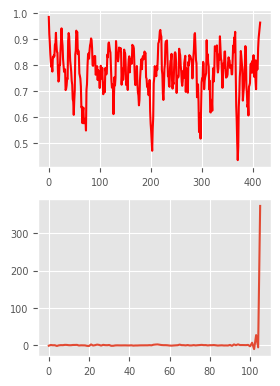

KeyboardInterrupt: 

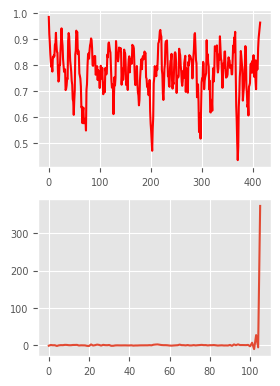

In [56]:
hidden_dim = 64
actor_lr = 1e-5# * 10
critic_lr = actor_lr * 10# * 100
Horizon_Length = 128
RollOuts = 1
batch_size = 32#Horizon_Length# * RollOuts
gamma = 0.95
max_stageCost = 1e4
EffectiveHorizonLength = (1 - gamma ** Horizon_Length) / (1 - gamma)
AGENT = agent(rx * 2,ru, hidden_dim, critic_lr, actor_lr, buffer_size = batch_size * 64, tau=0.05, gamma=gamma, device=device)
rewards = []
avg_rewards = []
NumberOf_Episodes = 1000
fig= plt.figure(figsize=(FigDim1,3 * FigDim2))
plt.style.use('ggplot')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 

for episode in range(NumberOf_Episodes):
    episode_reward = 0
    xx_rec = []
    Exploration_std = (NumberOf_Episodes - episode) / NumberOf_Episodes
    for trail in range(RollOuts):
        # Initial conditions of this rollout
        Cov0 = 1 * torch.diag(torch.rand(rx,))
        #Cov0[1,1] = 0.5 * torch.rand(1,)
        x0 = 10 * torch.randn(rx, 1)
        x0[1] = 1 + 0.1 * torch.randn(1,)
        x0[2] = -2 + 0.1 * torch.randn(1,)
        Hyperstate.ChangeInitialStates(x0, Cov0)
        # Horizon of this rollout
        true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step
        for k in range(Horizon_Length):
            state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1).to(device)
            action = AGENT.get_action(state)
            action = Exploration_std * torch.randn(ru,) + action
            action = action.to(deviceCPU)
            action = action.T
            # Adding some exploration effort
            action = torch.atleast_2d(action).detach()
            # Create a transition
            
            true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
            measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
            # reward function
            reward = rewardFunction1(Hyperstate.Mean, Hyperstate.Covariance, action, Q_lqr, R_lqr, max_stageCost, true_state)
            Test_Magnitudes = torch.cat((state, action), dim=1)
            if ((Test_Magnitudes.abs() > 10000).sum() > 0):
                reward = 0
                print('Failure')
                break
            # Advance to next hyperstate
            Hyperstate.ApplyEKF(action, measurement_Plus_realization)
            new_state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
            AGENT.Buffer.push(state, action.T, reward, new_state)
            state = new_state
            episode_reward += reward * gamma ** k
            true_state = true_state_Plus
            xx_rec.append(Hyperstate.Mean[0].detach().numpy())
    if len(AGENT.Buffer)>= batch_size:
        for jjj in  range(8):
            AGENT.train_critic(batch_size)
        for jjj in  range(1):
            AGENT.train_actor(batch_size*1) 
    
    EffectiveHorizonLength = (1 - gamma ** k) / (1 - gamma)
    rewards.append(episode_reward.numpy() / (EffectiveHorizonLength * RollOuts))
    avg_rewards.append(np.mean(rewards[-5:]))


    if (True):
        plt.clf()
        plt.subplot(2, 1, 1)
        plt.plot(avg_rewards, 'r')
        plt.subplot(2, 1, 2)
        plt.plot(xx_rec)
        display.clear_output(wait=True)
        display.display(plt.gcf())
    



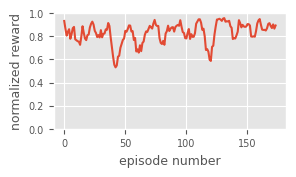

In [ ]:
plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 
plt.plot(avg_rewards)
plt.ylim([0.0, 1])
if saveFigs==True:
    plt.savefig('Figures/Example1_avgReward.pdf',bbox_inches ="tight")
plt.show()


K = AGENT.get_action#get_action

with open('Data/StateFeedbackGainFunction.pkl', 'wb') as outp:
    pickle.dump(K, outp, pickle.HIGHEST_PROTOCOL)

#with open('StateFeedbackGainFunction.pkl', 'rb') as inp:
    #K1 = pickle.load(inp)

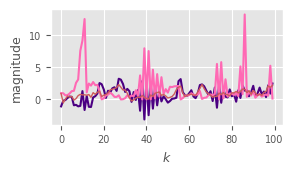

In [ ]:
T = 100

StateRec = deque([])
CovRec = deque([])
ActionRec = deque([])
StateRec_true = deque([])
Cov0 = 1 * torch.diag(torch.rand(rx,))
x0 = 1 * torch.randn(rx, 1)
Hyperstate.ChangeInitialStates(x0, Cov0)
true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step


for k in range(T):
    state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
    action = K(state)
    action = torch.atleast_2d(action.detach()).T
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
    StateRec.append(Hyperstate.Mean)
    CovRec.append(Hyperstate.Covariance)
    ActionRec.append(action)
    StateRec_true.append(true_state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
x = np.ones((rx, T))
x_true = np.ones((rx, T))
P = np.ones((rx ** 2, T))
for i in range(T):
    x[:,i] = StateRec[i].detach().numpy().squeeze()
    x_true[:,i] = StateRec_true[i].detach().numpy().squeeze()
    P[:,i] = CovRec[i].detach().numpy().squeeze().flatten()

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 

k=56
plt.plot(range(T), x[0,:], color=list(colors.cnames)[k+4])
plt.plot(range(T), P[0,:], color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])

if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


In [ ]:
T = 15

StateRec = deque([])
ActionRec = deque([])
StateRec_true = deque([])
Cov0 = 10 * torch.diag(torch.rand(rx,))
x0 = 10 * torch.randn(rx, 1)
Hyperstate.ChangeInitialStates(x0, Cov0)
true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step

for k in range(T):
    action = torch.from_numpy(-Klqr) @ Hyperstate.Mean
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
    StateRec.append(Hyperstate.Mean)
    ActionRec.append(action)
    StateRec_true.append(true_state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
x = np.ones((rx, T))
x_true = np.ones((rx, T))
for i in range(T):
    x[:,i] = StateRec[i].detach().numpy().squeeze()
    x_true[:,i] = StateRec_true[i].detach().numpy().squeeze()

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 

k=56
plt.plot(range(T), x[0,:], color=list(colors.cnames)[k+4])
#plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])

if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


NameError: name 'Klqr' is not defined

In [ ]:
print(StateRec[0].detach().numpy())

In [ ]:
u = torch.tensor([[1.0],[2.0]])
x = torch.tensor([[5.0, 1.0, 3.2]]).T
print(x[0])
print(stateDynamics(x, u))
print(f_Jacobian(x, u).trace())

In [ ]:
A = torch.tensor([[0.9, 0, 0],
                  [-0.05, 0.8, 0],
                  [-0.2, 0, 0.95]])
L, V = torch.linalg.eig(A)
print(L)

In [ ]:
print(torch.diag(Hyperstate.Covariance).unsqueeze(0))
print(Hyperstate.Mean.T)
print(torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1))

In [ ]:
Hyperstate.Covariance = Hyperstate.Covariance + -0.001
print(Hyperstate.Covariance)
sqrtm(Hyperstate.Covariance @ Hyperstate.Covariance)

In [ ]:
rx = 3
torch.zeros(rx, 1)